<a href="https://colab.research.google.com/github/Kaizokoo/Neural-Networks-and-SGD/blob/main/Neural_Networks_and_SGD_(Deep_Learning).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **The code below shows the the implementation of Batched Stochastic Gradient Descent from scratch using only Pytorch functions for a logistic regression model.**


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

In [ ]:
def generate_data():
  data = torch.rand(1000, 2)
  label = ((data[:,0]+0.3*data[:,1]) > 0.5).to(torch.int)
  return data[:,0], label

Epoch 1, Loss: 414.7435801625252
Epoch 2, Loss: 270.2218483686447
Epoch 3, Loss: 230.808384090662
Epoch 4, Loss: 211.86586713790894
Epoch 5, Loss: 200.5813359171152
Epoch 6, Loss: 193.06252935528755
Epoch 7, Loss: 187.69496922194958
Epoch 8, Loss: 183.67929057776928
Epoch 9, Loss: 180.57132451236248
Epoch 10, Loss: 178.10324550420046
Epoch 11, Loss: 176.10340755432844
Epoch 12, Loss: 174.45649142563343
Epoch 13, Loss: 173.0819850936532
Epoch 14, Loss: 171.92197701334953
Epoch 15, Loss: 170.93367512524128


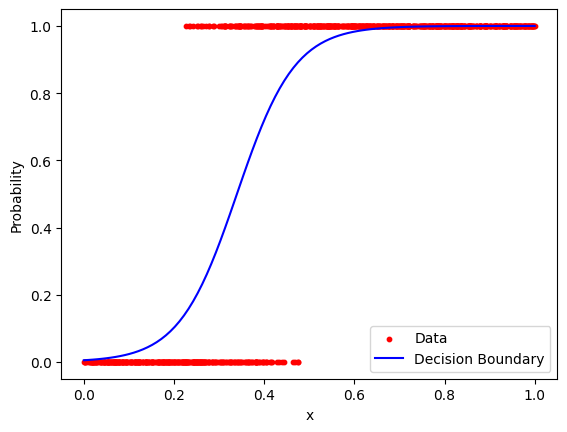

In [ ]:
input, label = generate_data()

# Make minibatches.
inputs = torch.split(input, 32)
labels = torch.split(label, 32)

# Define the two variables to optimize
b1 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)
b2 = torch.autograd.Variable(torch.tensor([0.01]), requires_grad=True)

learning_rate = 0.1

for epoch in range(15):
    total_loss = 0
    for x, y in zip(inputs, labels):
        # Calculate p_x as per formula above
        probability = 1 / (1 + torch.exp(-1 * (b1 + b2 * x)))

        # Calculate the negative loss likelihood
        loss = -torch.sum(y * torch.log(probability) + (1 - y) * torch.log(1 - probability))

        # Calculate the gradient of the loss w.r.t. the inputs
        loss.backward()

        # Update the parameters b according to SGD formula
        with torch.no_grad():
            b1 -= learning_rate * b1.grad
            b2 -= learning_rate * b2.grad

        # Zero the gradients after updating
        b1.grad.zero_()
        b2.grad.zero_()

        total_loss += loss.item()

    # Print out the loss value
    print(f'Epoch {epoch+1}, Loss: {total_loss}')


# Reproduce the image above to validate your result.
x_range = torch.linspace(0, 1, 100)
decision_boundary = 1 / (1 + torch.exp(-1 * (b1 + b2 * x_range)))
plt.scatter(input, label, color='red', label='Data', s = 10)
plt.plot(x_range.detach().numpy(), decision_boundary.detach().numpy(), color='blue', label='Decision Boundary')
plt.xlabel('x')
plt.ylabel('Probability')
plt.legend()
plt.show()

## **GRU model for predicting time-series data.**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd

In [ ]:
class Net(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, output_size=2, num_layers=2):
        super(Net, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, csv_url):
        self.data = pd.read_csv(csv_url, na_values='-')
        self.data.dropna(inplace=True)
        self.times = torch.tensor(self.data['t'].values, dtype=torch.float32).unsqueeze(1)
        self.values = torch.tensor(self.data[['x', 'y']].values, dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        time = self.times[idx].unsqueeze(0)
        values = self.values[idx]
        return time, values

In [ ]:
dataset = TimeSeriesDataset('https://gist.githubusercontent.com/tmramalho/51733432c88e2b834dbd70353849f887/raw/676636d9e8512963005a318cb9b98060feadb641/data.csv')
trainloader = torch.utils.data.DataLoader(
    dataset, batch_size=32, shuffle=True, num_workers=2)

def loss_fn(outputs, labels):
    return nn.MSELoss()(outputs, labels)

net = Net()
optimizer = optim.Adam(net.parameters(), lr=0.005) # why is it good?

In [ ]:
# Training loop
for epoch in range(300):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print every 20th epoch
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch + 1}/{300}, Loss: {running_loss / len(trainloader):.3f}")

print('Finished Training')

Epoch 20/300, Loss: 5.484
Epoch 40/300, Loss: 4.259
Epoch 60/300, Loss: 2.133
Epoch 80/300, Loss: 0.864
Epoch 100/300, Loss: 1.495
Epoch 120/300, Loss: 0.887
Epoch 140/300, Loss: 0.734
Epoch 160/300, Loss: 0.487
Epoch 180/300, Loss: 0.754
Epoch 200/300, Loss: 0.466
Epoch 220/300, Loss: 0.397
Epoch 240/300, Loss: 0.817
Epoch 260/300, Loss: 0.375
Epoch 280/300, Loss: 0.361
Epoch 300/300, Loss: 0.378
Finished Training


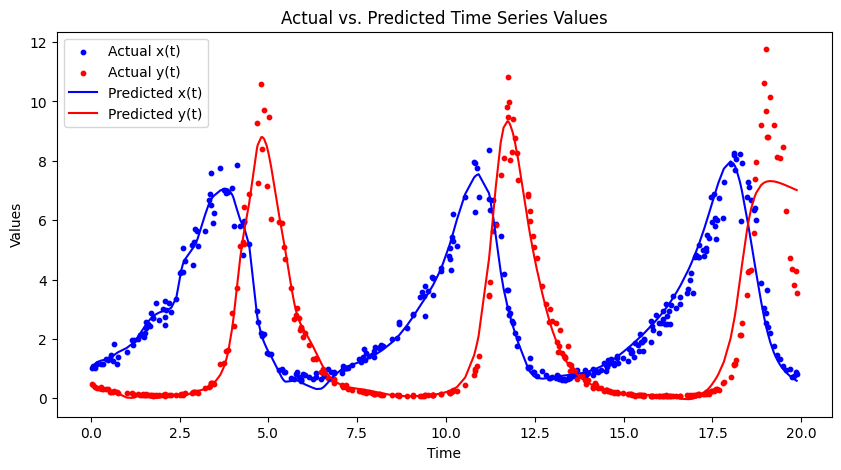

In [ ]:
# Plot results to validate training
times = dataset.times.unsqueeze(1)
predicted_values = net(times).detach().numpy()
actual_values = dataset.values.numpy()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(times.squeeze().numpy(), actual_values[:, 0], label='Actual x(t)', color='blue', marker='o', s=10)
plt.scatter(times.squeeze().numpy(), actual_values[:, 1], label='Actual y(t)', color='red', marker='o', s=10)
plt.plot(times.squeeze().numpy(), predicted_values[:, 0], label='Predicted x(t)', linestyle='solid', color='blue')
plt.plot(times.squeeze().numpy(), predicted_values[:, 1], label='Predicted y(t)', linestyle='solid', color='red')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Actual vs. Predicted Time Series Values')
plt.show()

## **A Bi-directional ARIMA based neural network model made in pytorch used to forecast the same time series data as above with good accuracy.**

Training with seed: 88


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 50/500, Loss: 0.0081
Epoch 100/500, Loss: 0.0064
Epoch 150/500, Loss: 0.0058
Epoch 200/500, Loss: 0.0049
Epoch 250/500, Loss: 0.0052
Epoch 300/500, Loss: 0.0050
Epoch 350/500, Loss: 0.0047
Epoch 400/500, Loss: 0.0052
Epoch 450/500, Loss: 0.0048
Epoch 500/500, Loss: 0.0048


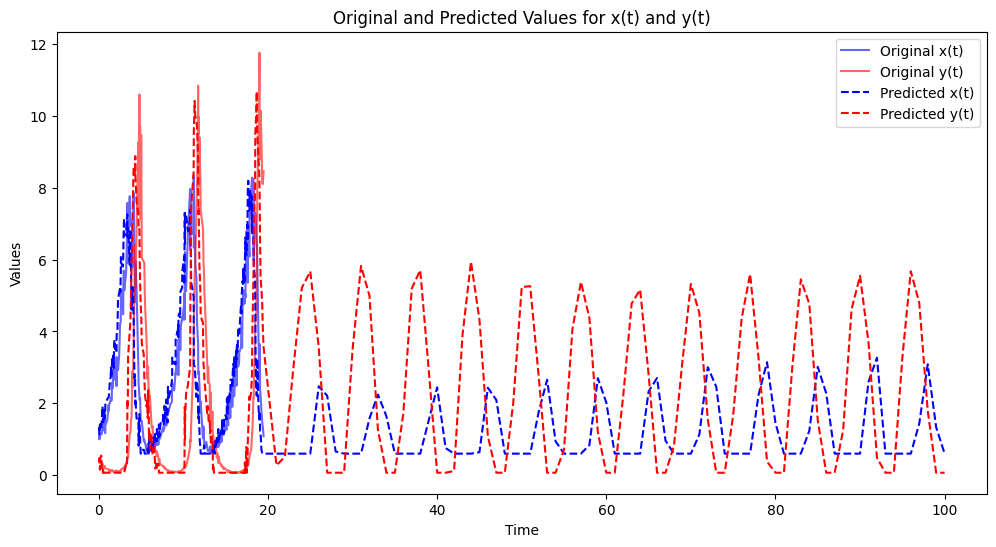

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Training with seed: {seed}")

class PeriodicTimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, csv_url, window_size=6.5, period=6.5):
        self.data = pd.read_csv(csv_url, na_values='-')
        self.data.dropna(inplace=True)

        self.scaler = MinMaxScaler()
        self.data[['x', 'y']] = self.scaler.fit_transform(self.data[['x', 'y']])

        self.data['sin_t'] = np.sin(2 * np.pi * self.data['t'] / period)
        self.data['cos_t'] = np.cos(2 * np.pi * self.data['t'] / period)

        self.window_size = int(window_size)
        self.inputs = []
        self.targets = []
        for i in range(len(self.data) - self.window_size):
            window_input = self.data.iloc[i:i+self.window_size][['x', 'y', 'sin_t', 'cos_t']].values
            self.inputs.append(torch.tensor(window_input, dtype=torch.float32))
            self.targets.append(torch.tensor(self.data.iloc[i+self.window_size][['x', 'y']].values, dtype=torch.float32))

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

class Attention(nn.Module):
    def __init__(self, hidden_size):
        super(Attention, self).__init__()
        self.hidden_size = hidden_size
        self.attention_weights = nn.Linear(hidden_size, 1, bias=False)

    def forward(self, gru_output):
        attention_scores = self.attention_weights(gru_output)
        attention_weights = torch.softmax(attention_scores, dim=1)
        context_vector = torch.sum(attention_weights * gru_output, dim=1)
        return context_vector

class EnhancedGRUWithAttentionResidualModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=2, num_layers=3, dropout=0.3):
        super(EnhancedGRUWithAttentionResidualModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.attention = Attention(hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.residual_fc = nn.Linear(input_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)

        gru_out, _ = self.gru(x, h0)
        context_vector = self.attention(gru_out)
        out = self.fc(context_vector)
        residual_out = self.residual_fc(x[:, -1, :])
        out = self.relu(out + residual_out)
        return out

class WeightedMSELoss(nn.Module):
    def __init__(self, weight):
        super(WeightedMSELoss, self).__init__()
        self.weight = weight

    def forward(self, input, target):
        return torch.mean(self.weight * (input - target) ** 2)

def train_and_predict(csv_url, learning_rate=0.0005, epochs=2000, window_size=6.5, period=6.5, seed=42):
    set_seed(seed)  # Set the seed for reproducibility

    dataset = PeriodicTimeSeriesDataset(csv_url, window_size=window_size, period=period)
    trainloader = torch.utils.data.DataLoader(
        dataset, batch_size=32, shuffle=False, num_workers=0, pin_memory=True
    )

    input_size = 4
    model = EnhancedGRUWithAttentionResidualModel(input_size=input_size, num_layers=3, hidden_size=128, output_size=2, dropout=0.3).to(device)

    criterion = WeightedMSELoss(weight=torch.tensor([2.0]).to(device))
    optimizer = optim.NAdam(model.parameters(), lr=learning_rate)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=20, factor=0.5, verbose=True)

    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data

            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        if epoch % 50 == 49:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(trainloader):.4f}")

        scheduler.step(running_loss)

    predicted_values = []
    for input_value in dataset.inputs:
        with torch.no_grad():
            input_value = input_value.to(device)
            output = model(input_value.unsqueeze(0))
            predicted_values.append(output.squeeze().cpu().numpy())

    predicted_values = np.array(predicted_values)

    last_input = dataset.inputs[-1].cpu().numpy()
    future_predictions = []

    future_times = np.arange(21, 101)
    future_sin_t = np.sin(2 * np.pi * future_times / period)
    future_cos_t = np.cos(2 * np.pi * future_times / period)

    for i, t in enumerate(future_times):
        last_input = np.roll(last_input, -1, axis=0)

        new_input = np.array([[last_input[-1, 0], last_input[-1, 1], future_sin_t[i], future_cos_t[i]]])

        last_input[-1] = new_input.flatten()

        input_tensor = torch.tensor(last_input, dtype=torch.float32).unsqueeze(0).to(device)

        with torch.no_grad():
            output = model(input_tensor)
            future_predictions.append(output.squeeze().cpu().numpy())

    future_predictions = np.array(future_predictions)

    predicted_x = np.concatenate((predicted_values[:, 0], future_predictions[:, 0]))
    predicted_y = np.concatenate((predicted_values[:, 1], future_predictions[:, 1]))

    predicted_xy = np.stack((predicted_x, predicted_y), axis=-1)
    predicted_xy = dataset.scaler.inverse_transform(predicted_xy)

    predicted_x = predicted_xy[:, 0]
    predicted_y = predicted_xy[:, 1]

    original_values = dataset.scaler.inverse_transform(dataset.data[['x', 'y']].values[:len(predicted_values)])

    original_t = dataset.data['t'].values[:len(predicted_values)]
    total_time_range = np.concatenate((original_t, future_times))

    return predicted_x, predicted_y, total_time_range, original_values

csv_url = 'https://gist.githubusercontent.com/tmramalho/51733432c88e2b834dbd70353849f887/raw/676636d9e8512963005a318cb9b98060feadb641/data.csv'

predicted_x, predicted_y, total_time_range, original_values = train_and_predict(csv_url, learning_rate=0.0008, epochs=500, window_size=6.5, period=6.5, seed=88)

plt.figure(figsize=(12, 6))
plt.plot(total_time_range[:len(original_values)], original_values[:, 0], label='Original x(t)', color='blue', alpha=0.6)
plt.plot(total_time_range[:len(original_values)], original_values[:, 1], label='Original y(t)', color='red', alpha=0.6)
plt.plot(total_time_range, predicted_x, label='Predicted x(t)', linestyle='dashed', color='blue')
plt.plot(total_time_range, predicted_y, label='Predicted y(t)', linestyle='dashed', color='red')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Original and Predicted Values for x(t) and y(t)')
plt.show()

# Used a Bi Directional ARIMA because it was showing the best results for t > 20 for a neural network out of all the networks I tried.
# Using an NADAM optimizer as it is slightly better at getting out of local minimas
# This code provides best results when the final loss is less than 0.009, does have the tendency to get stuck in some local minima which causes bad training hence the use of a seed


## **The Below part is just for a little fun; wanted to highlight a very computationally cheap way to solve the above problem with an okay solution.**


<ipython-input-18-bf8c60584e25>:18: OptimizeWarning: Covariance of the parameters could not be estimated
  params_x, _ = curve_fit(clipped_triangle_wave, t, x, p0=[1, 10, 0, 0, 0, -1])


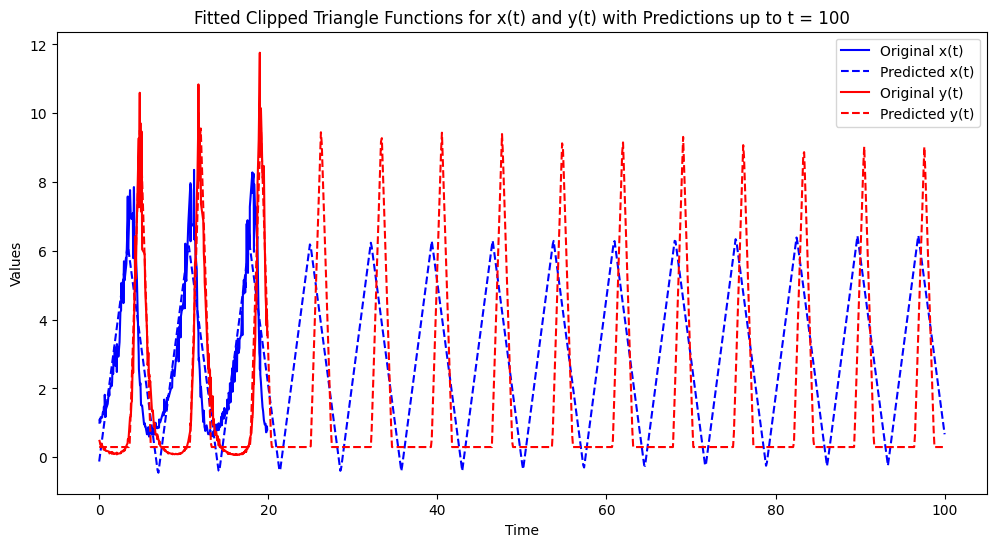

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

csv_url = 'https://gist.githubusercontent.com/tmramalho/51733432c88e2b834dbd70353849f887/raw/676636d9e8512963005a318cb9b98060feadb641/data.csv'
data = pd.read_csv(csv_url, na_values='-')
data.dropna(inplace=True)

t = data['t'].values
x = data['x'].values
y = data['y'].values

def clipped_triangle_wave(t, amplitude, period, phase, a, k, clip_value):
    wave = amplitude * np.abs((t + phase) % period - period/2) - amplitude/2 + a * t + k
    return np.maximum(wave, clip_value)

params_x, _ = curve_fit(clipped_triangle_wave, t, x, p0=[1, 10, 0, 0, 0, -1])
params_y, _ = curve_fit(clipped_triangle_wave, t, y, p0=[1, 10, 0, 0, 0, -1])

t_future = np.linspace(0, 100, 1000)
x_pred = clipped_triangle_wave(t_future, *params_x)
y_pred = clipped_triangle_wave(t_future, *params_y)

plt.figure(figsize=(12, 6))
plt.plot(t, x, label='Original x(t)', color='blue')
plt.plot(t_future, x_pred, label='Predicted x(t)', linestyle='dashed', color='blue')
plt.plot(t, y, label='Original y(t)', color='red')
plt.plot(t_future, y_pred, label='Predicted y(t)', linestyle='dashed', color='red')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.title('Fitted Clipped Triangle Functions for x(t) and y(t) with Predictions up to t = 100')
plt.show()
